In [31]:
!pip install pyspark
!pip install tensorflowonspark

In [32]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import tensorflow as tf
import tensorflowonspark as tfos
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pyspark.sql.functions as F
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [33]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("AndroidMalwareDetection") \
    .getOrCreate()

In [34]:
# Load the dataset into a Spark DataFrame
dataset_path = "Android Malware Detection.csv"
df = spark.read.csv(dataset_path, header=True, inferSchema=True)

In [35]:
# Display the schema and first few rows of the DataFrame
df.printSchema()
df.show(5)

root
 |-- _c0: integer (nullable = true)
 |-- ACCESS_ALL_DOWNLOADS: double (nullable = true)
 |-- ACCESS_CACHE_FILESYSTEM: double (nullable = true)
 |-- ACCESS_CHECKIN_PROPERTIES: double (nullable = true)
 |-- ACCESS_COARSE_LOCATION: double (nullable = true)
 |-- ACCESS_FINE_LOCATION: double (nullable = true)
 |-- ACCESS_LOCATION_EXTRA_COMMANDS: double (nullable = true)
 |-- ACCESS_MOCK_LOCATION: double (nullable = true)
 |-- ACCESS_NETWORK_STATE: double (nullable = true)
 |-- ACCESS_SURFACE_FLINGER: double (nullable = true)
 |-- ACCESS_WIFI_STATE: double (nullable = true)
 |-- ACCOUNT_MANAGER: double (nullable = true)
 |-- AUTHENTICATE_ACCOUNTS: double (nullable = true)
 |-- BATTERY_STATS: double (nullable = true)
 |-- BIND_ACCESSIBILITY_SERVICE: double (nullable = true)
 |-- BIND_APPWIDGET: double (nullable = true)
 |-- BIND_CARRIER_MESSAGING_SERVICE: double (nullable = true)
 |-- BIND_DEVICE_ADMIN: double (nullable = true)
 |-- BIND_DREAM_SERVICE: double (nullable = true)
 |-- BIND_

In [36]:
# Count the number of rows in the dataset
row_count = df.count()
print("Number of rows in the dataset:", row_count)

Number of rows in the dataset: 4863


In [37]:
# Summary statistics
print("Summary Statistics:")
df.describe().show()

Summary Statistics:
+-------+------------------+--------------------+-----------------------+-------------------------+----------------------+--------------------+------------------------------+--------------------+--------------------+----------------------+------------------+-------------------+---------------------+-------------------+--------------------------+-------------------+------------------------------+--------------------+--------------------+---------------------------------+--------------------+----------------------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+---------------------

Feature Correlations:


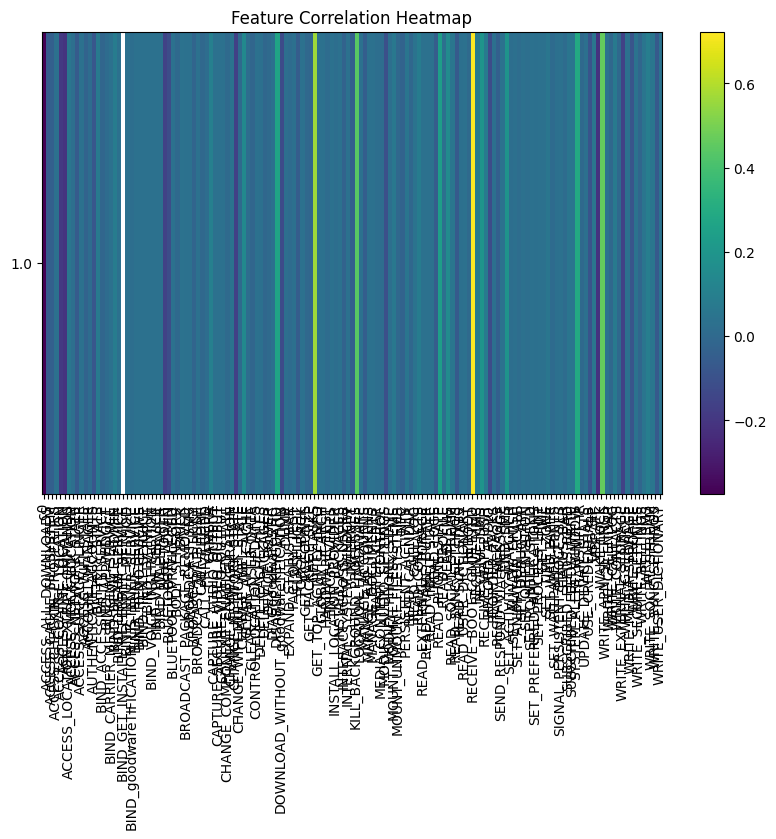

In [38]:
# Feature correlations
print("Feature Correlations:")
correlation_matrix = df.select([F.corr(col, 'Label').alias(col) for col in df.columns]).toPandas().set_index('Label')
plt.figure(figsize=(10, 6))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
plt.title('Feature Correlation Heatmap')
plt.show()

In [39]:
# Check the class distribution
class_distribution = df.groupBy("Label").count().orderBy("Label")
class_distribution.show()

+-----+-----+
|Label|count|
+-----+-----+
| NULL|    1|
|  0.0| 1098|
|  1.0| 3764|
+-----+-----+



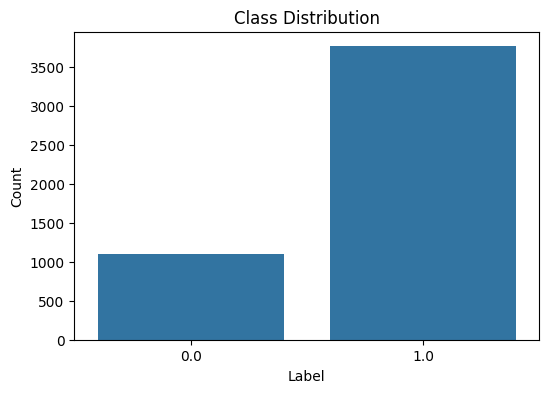

In [40]:
# Visualize the class distribution
class_distribution_pd = class_distribution.toPandas()
plt.figure(figsize=(6, 4))
sns.barplot(x="Label", y="count", data=class_distribution_pd)
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Exception ignored in: <function JavaWrapper.__del__ at 0x7deed7305ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'


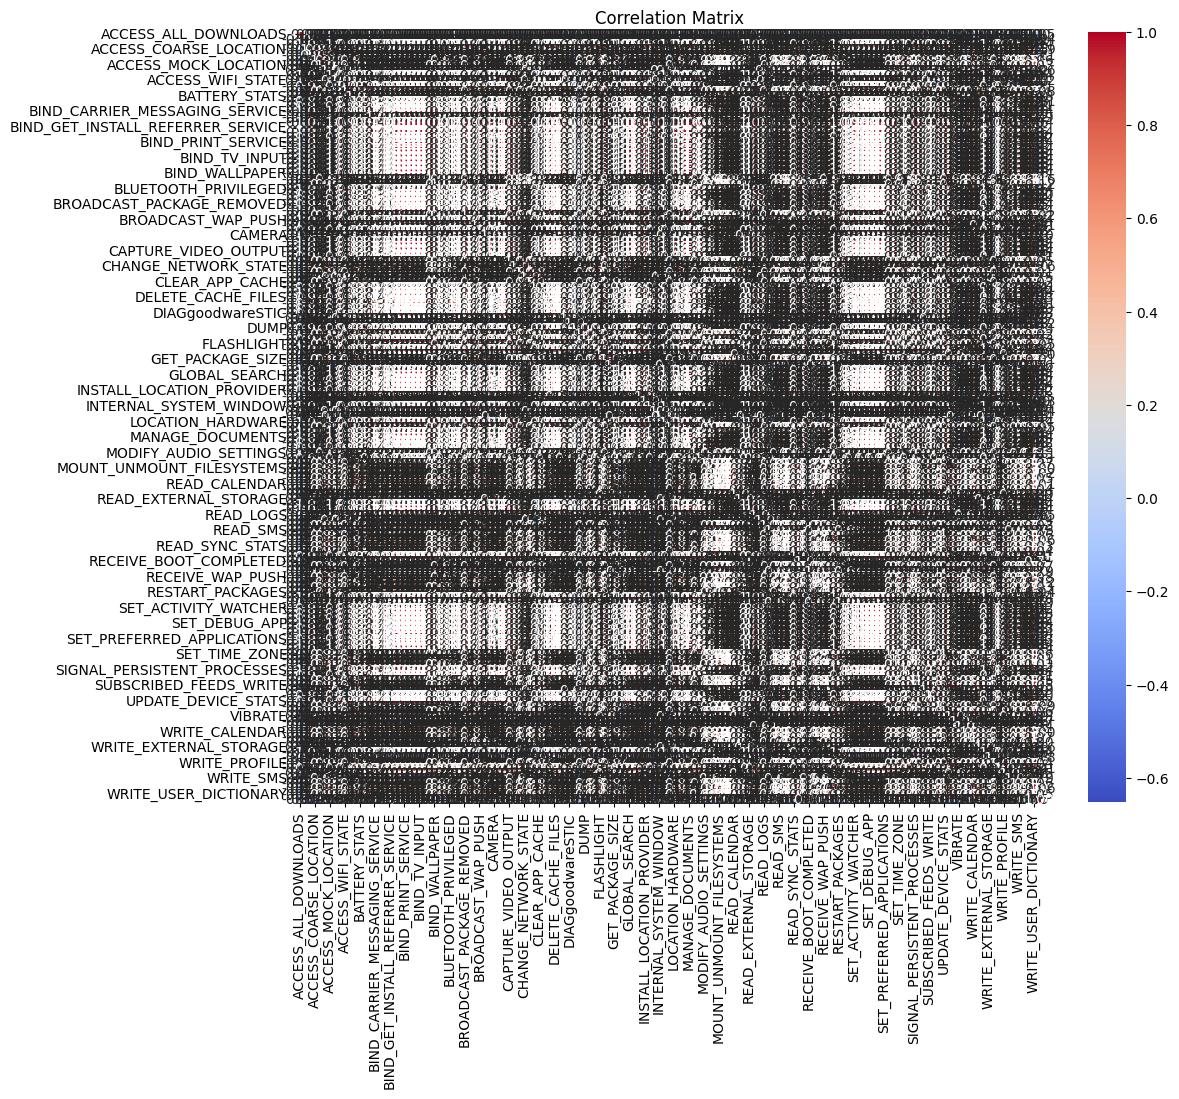

In [41]:
# Correlation Analysis
correlation_matrix = df.drop("_c0").toPandas().corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [42]:
df = df.na.drop()

In [43]:
# Assemble features
feature_cols = df.columns[1:-1]  # Exclude _c0 and Label columns
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_assembled = assembler.transform(df)

In [44]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(labelCol="Label", featuresCol="features", numTrees=100)
model = rf.fit(data_assembled)

In [45]:
# Get feature importances
feature_importances = model.featureImportances.toArray()

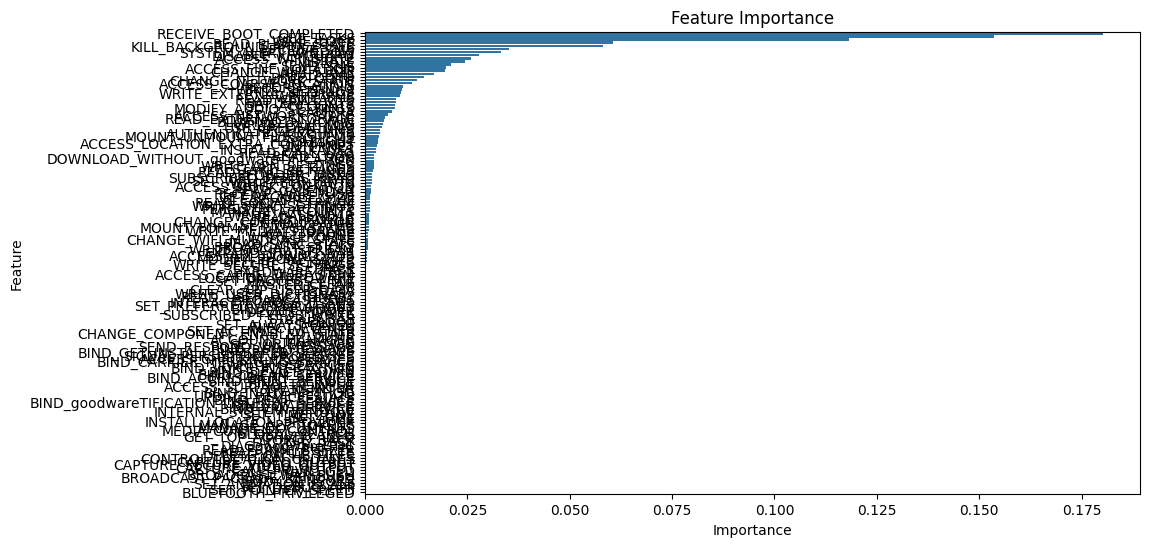

In [46]:
# Visualize feature importances
feature_importance_pd = pd.DataFrame({"Feature": feature_cols, "Importance": feature_importances})
feature_importance_pd_sorted = feature_importance_pd.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_pd_sorted)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [47]:
from pyspark.ml.feature import VectorSlicer

# Get the indices of the top 20 features based on their importances
top_20_indices = feature_importances.argsort()[-20:][::-1]

# Select only the top 20 features from the feature vector
slicer = VectorSlicer(inputCol="features", outputCol="selected_features", indices=top_20_indices)
data_selected = slicer.transform(data_assembled)

# Train the RandomForestClassifier model using only the top 20 features
rf_selected = RandomForestClassifier(labelCol="Label", featuresCol="selected_features", numTrees=100)
model_selected = rf_selected.fit(data_selected)

In [48]:
# Split the data into training and testing sets
train_data_selected, test_data_selected = data_selected.randomSplit([0.8, 0.2], seed=42)

# Evaluate the model's performance on the testing set
evaluator = BinaryClassificationEvaluator(labelCol="Label")
test_predictions = model_selected.transform(test_data_selected)
auc = evaluator.evaluate(test_predictions)
print("AUC on the testing set:", auc)

# Calculate accuracy
accuracy = test_predictions.filter("prediction == Label").count() / test_predictions.count()
print("Accuracy on the testing set:", accuracy)

# Calculate precision
precision = test_predictions.filter("prediction == 1 AND Label == 1").count() / test_predictions.filter("prediction == 1").count()
print("Precision on the testing set:", precision)

# Calculate recall
recall = test_predictions.filter("prediction == 1 AND Label == 1").count() / test_predictions.filter("Label == 1").count()
print("Recall on the testing set:", recall)

AUC on the testing set: 0.9916187834357045
Accuracy on the testing set: 0.966702470461869
Precision on the testing set: 0.9765193370165746
Recall on the testing set: 0.9805825242718447


In [ ]:
# Stop the SparkSession
spark.stop()